In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

import matplotlib.pyplot as plt
import seaborn as sns
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc

import pandas as pd
import os
import numpy as np

from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

from joblib import load, dump

In [9]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_kernel = gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(1e-3, 1e2))
        
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel, outputscale_constraint=gpytorch.constraints.Interval(1e-3, 1e3))


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Load data
def load_data(file_path):
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    # Use StandardScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[['distance_along_streakline', 'nearest_from_streakline']])
    
    X = torch.tensor(X_scaled, dtype=torch.float32).cuda()
    y = torch.tensor(df['odor_binary'].values, dtype=torch.float32).cuda()
    return X, y, scaler

# Training function
def train_gp_for_file(file_path):
    X, y, scaler = load_data(file_path)  # Collect the scaler as well
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = GPModel(X, y, likelihood).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()
    
    for i in range(150):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        
    return model, scaler 

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
scalers = {}  # To store scalers corresponding to the models
for file_path in all_files:
    gp_model, scaler = train_gp_for_file(file_path)
    trained_models[file_path] = gp_model
    scalers[file_path] = scaler
    print(f"Completed training for file: {file_path}")
print("Done")

Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag32.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag50.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag12.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag6.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag52.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag41.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plum

### Performance of Train Data

/home/beast/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Accuracy: 0.8783333333333333


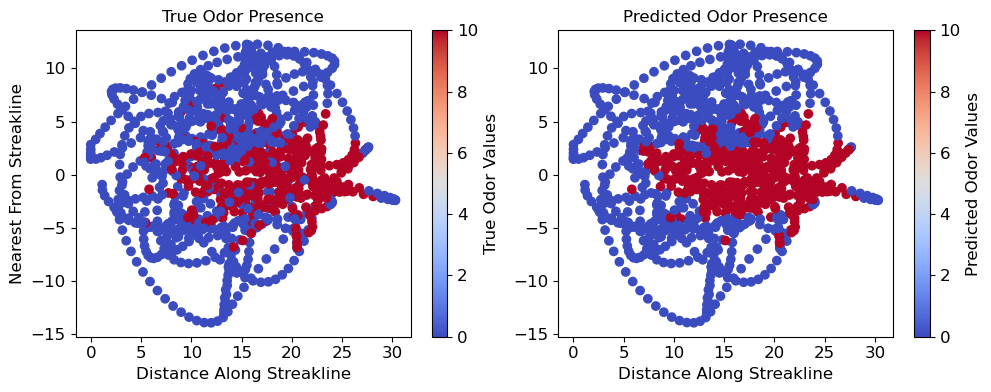

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]
scaler = scalers[test_file_path]  # Retrieve the scaler for this model

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Scale the test data using the scaler
X_test_scaled = scaler.transform(test_df[['distance_along_streakline', 'nearest_from_streakline']])

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_true = test_df['odor_binary'].values

# GP in eval mode
gp.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()
    y_pred_std = observed_pred.stddev.cpu().numpy()

y_pred_binary = np.where(y_pred_mean > 4, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")


f, axes = plt.subplots(1,2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')


sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')
# axes[1].set_ylabel('Nearest From Streakline')

f.tight_layout()

mpl_functions.set_fontsize(f, 12)


### Performance on Test Data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

representative_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5"
gp_representative = trained_models[representative_file_path].to(device)
scaler = scalers[representative_file_path]  # Retrieve the scaler for this model

test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/diag10.h5"
test_df = pd.read_hdf(test_file_path)

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

X_test_scaled = scaler.transform(test_df[['distance_along_streakline', 'nearest_from_streakline']])

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_true = test_df['odor_binary'].values

# Predict using the GP model
gp_representative.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp_representative(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()

y_pred_binary = np.where(y_pred_mean > 4, 10, 0)

accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Visualization
f, axes = plt.subplots(1, 2, figsize=(10, 4))
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()
mpl_functions.set_fontsize(f, 12)

In [17]:

# GP Model definition
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_kernel = gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(1e-3, 1e2))
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel, outputscale_constraint=gpytorch.constraints.Interval(1e-3, 1e3))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Load data without scaling
def load_data(file_path):
    df = pd.read_hdf(file_path)
    if 'odor_binary' not in df.columns:
        df['odor_binary'] = df['odor'].apply(lambda x: 10 if x > 0 else 0)
    
    X = torch.tensor(df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32).cuda()
    y = torch.tensor(df['odor_binary'].values, dtype=torch.float32).cuda()
    return X, y

# Training function
def train_gp_for_file(file_path):
    X, y = load_data(file_path)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = GPModel(X, y, likelihood).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()
    
    for i in range(200):
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        
    return model

# Training models
folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
for file_path in all_files:
    gp_model = train_gp_for_file(file_path)
    trained_models[file_path] = gp_model
    print(f"Completed training for file: {file_path}")
print("Done")

Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag32.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag39.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag50.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag12.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag15.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag6.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag52.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag41.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag21.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plume1/train/diag29.h5
Completed training for file: /home/beast/An/data/Sept13Plumes/plum

/home/beast/.local/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Accuracy: 0.8933333333333333


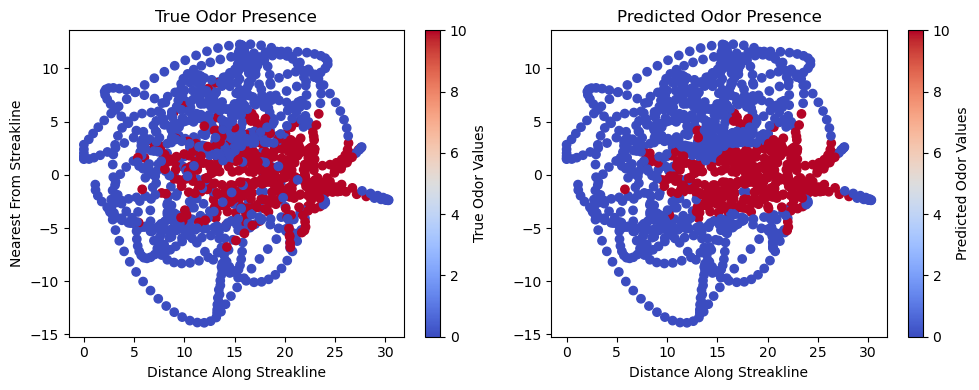

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing phase
test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

if 'odor_binary' not in test_df.columns:
    test_df['odor_binary'] = test_df['odor'].apply(lambda x: 10 if x > 0 else 0)

# Use original test data (without scaling)
X_test = test_df[['distance_along_streakline', 'nearest_from_streakline']].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_true = test_df['odor_binary'].values

# GP in eval mode
gp.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()
    y_pred_std = observed_pred.stddev.cpu().numpy()

# Binary prediction based on the mean prediction
y_pred_binary = np.where(y_pred_mean > 5, 10, 0)

# Evaluation metrics
accuracy = accuracy_score(y_true, y_pred_binary)
report = classification_report(y_true, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Visualization
f, axes = plt.subplots(1, 2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor_binary'], cmap='coolwarm')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Presence')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_binary, cmap='coolwarm')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Presence')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()